# GRAPH CONVOLUTIONAL NETWORKS FOR ANOMALY DETECTION

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import model_selection, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.parameter import Parameter

import time
import math
import random

In [8]:
manual_seed=7

## Loading Dataset
Cora dataset:

Nodes represent research papers
- Each paper has a feature vector that encodes information about the vocabulary used in the paper by using Bag of Words method.
- Each paper has a subject as a class that indicates the field of the paper.

Edges represent citation relationships between the papers (directed connection)

Dataset has 2708 papers (nodes) and 5429 citations (edges). 

The dictionary consists of 1433 unique words used to encode node feature vector.

In [9]:
# loading node information
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv('/Users/rohansingh/Documents/notebooks/csds_440/final_proj/cora/cora.content', sep='\t', names=column_names)

- num_node:    the number of node in dataset
- num_feature: the number of feature in a node
- node_index:  the node's Id list

In [10]:
num_node, num_feature = node_data.shape[0], node_data.shape[1]-1
node_index = np.array(node_data.index)
print("The number of node: {}".format(num_node))
print("The number of feature: {}".format(num_feature))

The number of node: 2708
The number of feature: 1433


In [11]:
# loading edge information
edge_list = pd.read_csv('./cora/cora.cites', sep='\t', names=['target', 'source'])
print("The number of edge: {}".format(edge_list.shape[0]))

The number of edge: 5429


## Classes Distribution

Class is the subject that a paper belongs to. There are 7 classes.

In [12]:
node_data['subject'].value_counts()

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Neural_Networks'),
  Text(1, 0, 'Probabilistic_Methods'),
  Text(2, 0, 'Genetic_Algorithms'),
  Text(3, 0, 'Theory'),
  Text(4, 0, 'Case_Based'),
  Text(5, 0, 'Reinforcement_Learning'),
  Text(6, 0, 'Rule_Learning')])

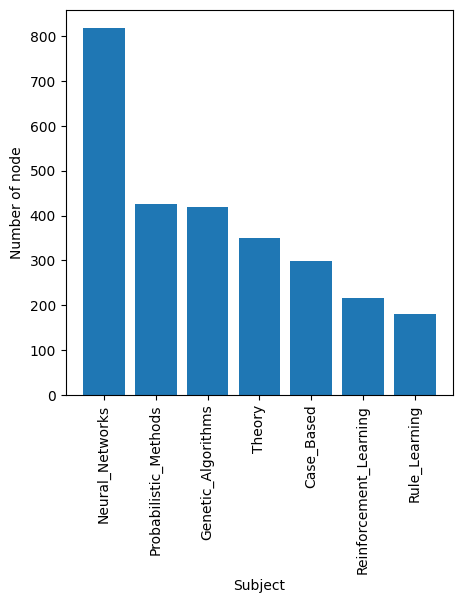

In [13]:
# plot distribution of subject
subject_count = node_data['subject'].value_counts()

plt.figure(figsize=(5,5))
plt.bar(subject_count.index, subject_count.values)
plt.xlabel('Subject')
plt.ylabel('Number of node')
plt.xticks(rotation=90)

## Distribution of the number of used word in a node feature vector

Text(0, 0.5, 'Frequency')

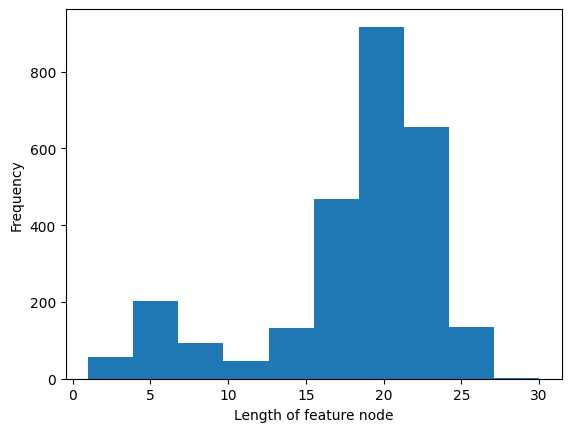

In [14]:
# calculate the number of used word in a node, then calculate distrubution
ax = node_data[feature_names].sum(axis=1).plot(kind='hist')
ax.set_xlabel("Length of feature node")
ax.set_ylabel("Frequency")

## Labeling anomaly and normal instance
we create a binary class problem by regarding the smallest class ('Rule_Learning') as anomalous and the remaining classes as normal.

we create a new column 'label' 

In [15]:
node_data['label'] = node_data['subject'].apply(lambda x: 'anomaly' if x == 'Rule_Learning' else 'normal')
node_data['label'].value_counts()

normal     2528
anomaly     180
Name: label, dtype: int64

We need a semi supervised problem to test our method, the ratio of
labeled instances and all instances is 10%. Therefore, we will randomly assigned 90% labeled instances into unlabeled instances.


In [16]:
# def f (x):
#     if random.random()<0.9:
#         return None
#     else:
#         return x

# node_data['label'] = node_data['label'].apply(f)
# node_data['label'].value_counts()

indices = np.arange(num_node)
unlabeled_data, labeled_data, index_unlabeled, index_labeled = train_test_split(node_data, indices, test_size=0.1, stratify=node_data['label'], random_state=123)

In [17]:
# set label of instances to 'unknown' as unlabeled instances
for idx in index_unlabeled:
    node_data['label'][node_index[idx]] = 'unknown'

/var/folders/yb/n2ch33ws4yzf1nn686jzrjs40000gn/T/ipykernel_73694/3009409276.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node_data['label'][node_index[idx]] = 'unknown'


In [18]:
node_data['label'].value_counts()

unknown    2437
normal      253
anomaly      18
Name: label, dtype: int64

## Train Test Splitting

Using train_test_split function:

- Split the dataset into train set and test set (80/20)

- Split the train set into train set and validation set (80/20)

Then save the index of labeled instances in train set, validation set and test set that used in training phase and evaluation

In [19]:
indices = np.arange(num_node)
train_data, test_data, index_train, index_test = train_test_split(node_data, indices, test_size=0.2, stratify=node_data['label'], random_state=manual_seed)

In [20]:
train_data, val_data, index_train, index_val = train_test_split(train_data, index_train, test_size=0.2, stratify=train_data['label'], random_state=manual_seed)

In [21]:
train_data['label'].value_counts()

unknown    1558
normal      162
anomaly      12
Name: label, dtype: int64

In [22]:
val_data['label'].value_counts()

unknown    391
normal      40
anomaly      3
Name: label, dtype: int64

In [23]:
test_data['label'].value_counts()

unknown    488
normal      51
anomaly      3
Name: label, dtype: int64

we have:

- index_train: the index of train set
- index_val: the index of validation set
- index_test: the index of test set

we want to have the index of normal and anomaly instance for each train set, validation set and test set 

In [24]:
index_normal_train = []
index_anomaly_train = []
for i in index_train:
    if node_data.iloc[i]['label'] == 'normal':
        index_normal_train.append(i)
    elif node_data.iloc[i]['label'] == 'anomaly':
        index_anomaly_train.append(i)

index_normal_val = []
index_anomaly_val = []
for i in index_val:
    if node_data.iloc[i]['label'] == 'normal':
        index_normal_val.append(i)
    elif node_data.iloc[i]['label'] == 'anomaly':
        index_anomaly_val.append(i)
        
index_normal_test = []
index_anomaly_test = []
for i in index_test:
    if node_data.iloc[i]['label'] == 'normal':
        index_normal_test.append(i)
    elif node_data.iloc[i]['label'] == 'anomaly':
        index_anomaly_test.append(i)
        
# print(index_normal_train)
# print(index_anomaly_train)

## Categories classes

we category classes as:
- anomaly instance: 1
- normal instance: 0

the unlabeled instances are assigned to -1

In [25]:
def f(x):
    if x == "anomaly":
        return 1
    elif x == "normal":
        return 0
    else:
        return -1

labels = node_data['label']
cat_labels = labels.apply(f)
        
cat_labels.value_counts()

-1    2437
 0     253
 1      18
Name: label, dtype: int64

In [26]:
# create torch tensor
cat_labels = torch.LongTensor(np.array(cat_labels))
features = torch.FloatTensor(np.array(node_data[feature_names]))

index_normal_train = torch.LongTensor(index_normal_train)
index_anomaly_train = torch.LongTensor(index_anomaly_train)

index_normal_val = torch.LongTensor(index_normal_val)
index_anomaly_val = torch.LongTensor(index_anomaly_val)

index_normal_test = torch.LongTensor(index_normal_test)
index_anomaly_test = torch.LongTensor(index_anomaly_test)

In [27]:
# check index
cat_labels[index_normal_test]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])

## Calculate adjacency matrix

In [28]:
# mapping the origin node's Id to a new order node's Id that is easier to create the adjacent matrix
index_map = {j: i for i, j in enumerate(node_index)}
adj = np.zeros((num_node, num_node))

# create an undirected adjacent matrix
for i in range(edge_list.shape[0]):
    u = edge_list['target'][i]
    v = edge_list['source'][i]
    adj[index_map[u], index_map[v]] = 1
    adj[index_map[v], index_map[u]] = 1

# plus adjacent matrix with with identity matrix
I = np.eye(num_node)
adj_tld = adj + I

# symmetric normalization
rowsum = np.sum(adj_tld, axis=1)
r_inv = rowsum ** -0.5
r_inv[np.isinf(r_inv)] = 0.    # check devided by 0
r_mat_inv = np.diag(r_inv)

adj_hat = np.dot( np.dot(r_mat_inv, adj_tld), r_mat_inv)    # r_mat_inv * adj_tld * r_mat_inv

adj = torch.FloatTensor(np.array(adj_hat))

## Model Architecture

The model has one hidden layer of 32 neurons. The output layer has 32 neurons as the embedding space

- nfeat  : number of feature in a node
- nhid   : number of neurons in hidden layer
- nclass : number of classes
- weight_in_hid  : weight between input and hidden layer
- bias_in_hid    : bias between input and hidden layer
- weight_hid_out : weight between hidden and output layer
- bias_hid_out   : bias between hidden and output layer

In [29]:
class GCN(nn.Module):
    def __init__(self, nfeat, nhid, nclass, dropout):
        super(GCN, self).__init__()
        self.nfeat = nfeat
        self.nhid = nhid
        self.nclass = nclass
        self.dropout = dropout
        
        # weight and bias between input and hidden layer
        self.weight_in_hid = Parameter(torch.FloatTensor(nfeat, nhid))
        self.bias_in_hid = Parameter(torch.FloatTensor(nhid))
        
        # weight and bias between hidden and output layer
        self.weight_hid_out = Parameter(torch.FloatTensor(nhid, nclass))
        self.bias_hid_out = Parameter(torch.FloatTensor(nclass))
        
        self.drop_layer = nn.Dropout(p=self.dropout)
        
        self.reset_parameters()
        
    def reset_parameters(self):
        torch.manual_seed(manual_seed)
        # use Glorot weight initialization
        stdv_in_hid = math.sqrt(6) / math.sqrt(self.nfeat + self.weight_in_hid.size(1))
        self.weight_in_hid.data.uniform_(-stdv_in_hid, stdv_in_hid)
        self.bias_in_hid.data.uniform_(-stdv_in_hid, stdv_in_hid)
        
        stdv_hid_out = math.sqrt(6) / math.sqrt(self.weight_in_hid.size(1) + self.weight_hid_out.size(1))
        self.weight_hid_out.data.uniform_(-stdv_hid_out, stdv_hid_out)
        self.bias_hid_out.data.uniform_(-stdv_hid_out, stdv_hid_out)
        
        
    def forward(self, x, adj):
        o_hidden = torch.mm(x, self.weight_in_hid)
        
        o_hidden = torch.spmm(adj, o_hidden)
        
        o_hidden = o_hidden + self.bias_in_hid
        
        o_hidden = F.relu(o_hidden)
        
        o_hidden = self.drop_layer(o_hidden)
        
        o_out = torch.mm(o_hidden, self.weight_hid_out)
        
        o_out = torch.spmm(adj, o_out)
        
        o_out = o_out + self.bias_hid_out
        
        return o_out
    
model = GCN(nfeat=features.shape[1],
            nhid=32,
            nclass=32,
            dropout=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
        

## Training model

In [30]:
import numpy as np
import torch

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [31]:
# calculate center after performing an initial forward pass.
# center is calculated by the mean of normal instances embedding.
model.eval()
normal_embed = model(features, adj)[index_normal_train].detach().numpy()
normal_embed = torch.FloatTensor(normal_embed)
center = torch.mean(normal_embed,0)

### Define the anomaly score function and loss functions as the paper:

Objective function consists of two terms:

- The first term (nor_loss) minimizes the volume of the hypersphere that encloses the node embeddings of normal instances.
- The second term (AUC_loss) encourages the score of anomaly instances to be higher than those of normal instances.

The anomaly score is defined for each node as the square Euclidean distance between the node embedding and the center c

In [32]:
def anomaly_score(node_embedding, c):
    # anomaly score of an instance is calculated by 
    # square Euclidean distance between the node embedding and the center c
    return torch.sum((node_embedding - c) ** 2)

def nor_loss(node_embedding_list, c):
    # normal loss is calculated by mean squared Euclidian distance of 
    # the normal node embeddings to hypersphere center c 
    s = 0
    num_node = node_embedding_list.size()[0]
    for i in range(num_node):
        s = s + anomaly_score(node_embedding_list[i], c)
    return s/num_node

def AUC_loss(anomaly_node_emb, normal_node_emb, c):
    # AUC_loss encourages the score of anomaly instances to be higher than those of normal instances
    s = 0
    num_anomaly_node = anomaly_node_emb.size()[0]
    num_normal_node = normal_node_emb.size()[0]
    for i in range(num_anomaly_node):
        for j in range(num_normal_node):
            s1 = anomaly_score(anomaly_node_emb[i], c)
            s2 = anomaly_score(normal_node_emb[j], c)
            s = s + torch.sigmoid(s1 - s2)
    return s/(num_anomaly_node * num_normal_node) # check devide by zero

def objecttive_loss(anomaly_node_emb, normal_node_emb, c, regularizer=1):
    Nloss = nor_loss(normal_node_emb, c)
    AUCloss = AUC_loss(anomaly_node_emb, normal_node_emb, c)
    loss = Nloss - regularizer * AUCloss
    return loss

hyperparameters:
- Adam optimizer with learning rate = 0.001
- Maximum number of epoch = 500
- EarlyStopping of val_loss with patience = 20

In [33]:
# Train model
EPOCH = 500
t_total = time.time()
train_losses = []
val_losses = []
AUC_regularizer = 1
early_stopping = EarlyStopping(patience=20, verbose=True)

for epoch in range(EPOCH):
    t = time.time()
    model.train()
    optimizer.zero_grad() #
    output = model(features, adj) #
    loss_train = objecttive_loss(output[index_anomaly_train], output[index_normal_train], center, AUC_regularizer) #
    loss_train.backward() #
    optimizer.step() #
    
    # evaluate in val set
    model.eval()
    output = model(features, adj)
    loss_val = objecttive_loss(output[index_anomaly_val], output[index_normal_val], center, AUC_regularizer) #
    
    train_losses.append(loss_train.detach().item())
    val_losses.append(loss_val.detach().item())
    
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'time: {:.4f}s'.format(time.time() - t))
    
    early_stopping(loss_val, model)
        
    if early_stopping.early_stop:
        print("Early stopping")
        break


print("Optimization Finished!")
print("Total time elapsed: {:.4f}s".format(time.time() - t_total))

# load the last checkpoint with the best model
model.load_state_dict(torch.load('checkpoint.pt'))

Epoch: 0001 loss_train: -0.4041 loss_val: -0.4578 time: 0.6695s
Validation loss decreased (inf --> -0.457821).  Saving model ...
Epoch: 0002 loss_train: -0.4308 loss_val: -0.4628 time: 0.3808s
Validation loss decreased (-0.457821 --> -0.462758).  Saving model ...
Epoch: 0003 loss_train: -0.4538 loss_val: -0.4674 time: 0.3592s
Validation loss decreased (-0.462758 --> -0.467389).  Saving model ...
Epoch: 0004 loss_train: -0.4559 loss_val: -0.4714 time: 0.3310s
Validation loss decreased (-0.467389 --> -0.471352).  Saving model ...
Epoch: 0005 loss_train: -0.4610 loss_val: -0.4750 time: 0.3487s
Validation loss decreased (-0.471352 --> -0.474965).  Saving model ...
Epoch: 0006 loss_train: -0.4802 loss_val: -0.4789 time: 0.5132s
Validation loss decreased (-0.474965 --> -0.478932).  Saving model ...
Epoch: 0007 loss_train: -0.4915 loss_val: -0.4831 time: 0.3529s
Validation loss decreased (-0.478932 --> -0.483090).  Saving model ...
Epoch: 0008 loss_train: -0.5123 loss_val: -0.4874 time: 0.360

<All keys matched successfully>

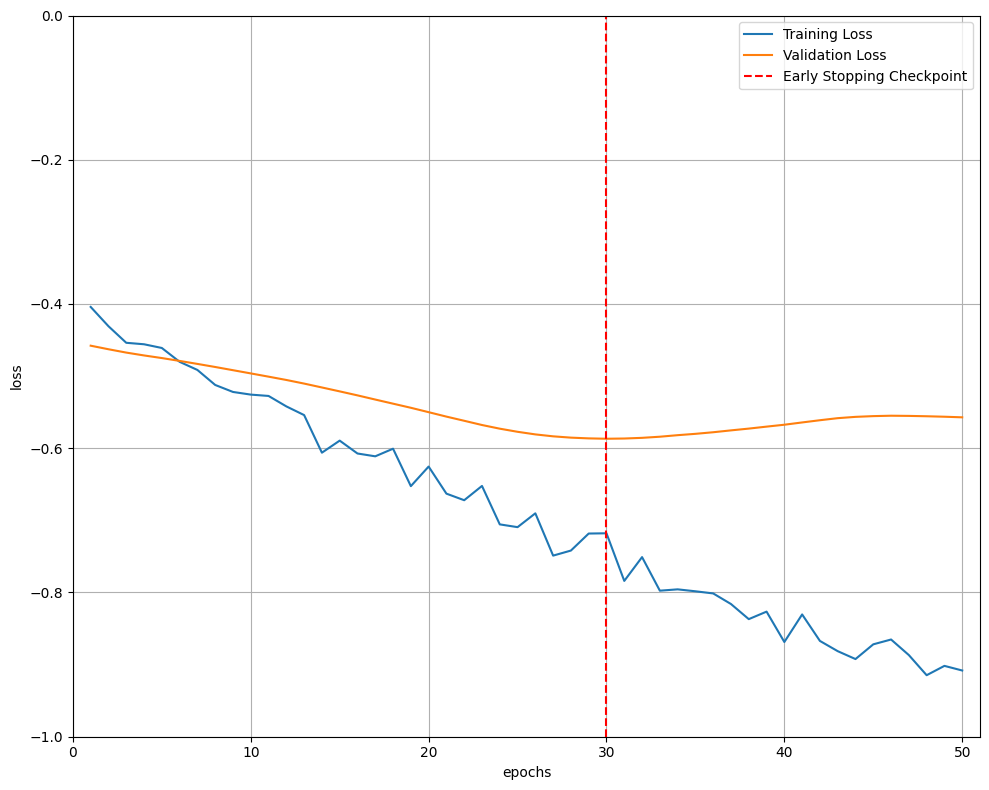

In [34]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_losses)+1),train_losses, label='Training Loss')
plt.plot(range(1,len(val_losses)+1),val_losses,label='Validation Loss')

# find position of lowest validation loss
minposs = val_losses.index(min(val_losses))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(-1.0, 0.0) # consistent scale
plt.xlim(0, len(train_losses)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

## Evaluate

Plot ROC curve and calculate AUC score on the test set

In [35]:
# label of anomaly and normal instances
anomaly_labels = list(cat_labels[index_anomaly_test].numpy())
normal_labels = list(cat_labels[index_normal_test].numpy())

model.eval()
# anomaly score of instances
output = torch.FloatTensor(model(features, adj).detach().numpy())
anomaly = output[index_anomaly_test]
normal = output[index_normal_test]
anomaly_s = []
normal_s = []

for i in range(anomaly.size()[0]):
    anomaly_s.append(anomaly_score(anomaly[i], center).item())
    
for i in range(normal.size()[0]):
    normal_s.append(anomaly_score(normal[i], center).item())


labels = anomaly_labels + normal_labels
scores = anomaly_s + normal_s

# calculate roc_auc_score
auc = roc_auc_score(labels, scores)
print("AUC score on test set = {}".format(auc))

AUC score on test set = 0.954248366013072


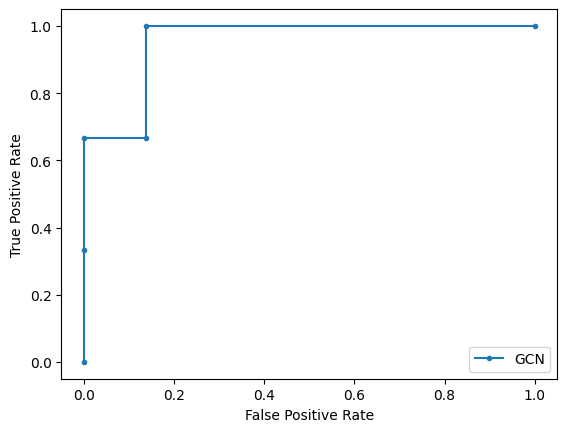

In [36]:
# plot roc curve
fpr, tpr, thresholds = roc_curve(labels, scores)
plt.plot(fpr, tpr, marker='.', label='GCN')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

## PCA and Visualize

We use the PCA to reduce the dimention of embedding space that we can easily visualize the data.

- Calculate covariance matrix of the data.
- Perform eigen-decomposition of the covariance matrix then choose the top 2 of eigen values and correspond eigen vetors.
- Project the origin data into the new plane formed by two pricipal eigen vetors.

In [37]:
from sklearn.preprocessing import StandardScaler

# take pairs of embedd_vector and label
model.eval()
output = torch.FloatTensor(model(features, adj).detach().numpy())
index = torch.cat([index_anomaly_train, index_anomaly_val, index_anomaly_test,
                   index_normal_train, index_normal_val, index_normal_test])
embedd_vectors = output[index]
labels = cat_labels[index]

# add the centers into embedd_vectors (we also want to visualize centers) and assign centers as label 2
embedd_vectors = torch.cat([embedd_vectors, torch.reshape(center,(1,-1)).type(torch.FloatTensor)], dim=0)
labels = torch.cat([labels, 2 * torch.ones(1).type(torch.LongTensor)])

# perform standardization
standard_embedd_vectors = StandardScaler().fit_transform(embedd_vectors)

In [38]:
from sklearn import decomposition
from scipy.linalg import eigh
import seaborn as sns

# pca = decomposition.PCA()
# pca.n_components = 2
# new_coordinates = pca.fit_transform(standard_embedd_vectors)

# Calculate covariance matrix
covar_matrix = (np.matmul(standard_embedd_vectors.T, standard_embedd_vectors))/standard_embedd_vectors.shape[0]

# Perform eigen-decomposition and choose the top 2 of eigen values and correspond eigen vetors
values, vectors = eigh(covar_matrix, eigvals=(30,31))

# Projecting 
new_coordinates = np.matmul(standard_embedd_vectors, vectors)

# visualize
new_df = pd.DataFrame({'Feature1': new_coordinates[:, 0], 'Feature2': new_coordinates[:, 1], 'Label': labels})
plt.figure(figsize=(10, 10))
sns.scatterplot(data=new_df, x="Feature1", y="Feature2", hue="Label", style="Label", size="Label", palette="deep")

ModuleNotFoundError: No module named 'seaborn'

### TSNE and Visualize

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
new_coordinates = tsne.fit_transform(standard_embedd_vectors)

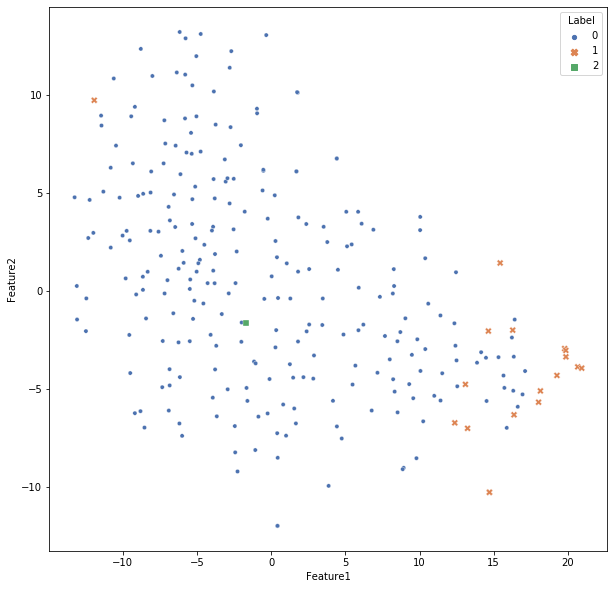

In [ ]:
# visualize
new_df = pd.DataFrame({'Feature1': new_coordinates[:, 0], 'Feature2': new_coordinates[:, 1], 'Label': labels})
plt.figure(figsize=(10, 10))
sns.scatterplot(data=new_df, x="Feature1", y="Feature2", hue="Label", style="Label", size="Label", palette="deep")

Blue circle: normal instance.

Orange cross: anomaly instance.

Green square: Center.

### Evaluate the average test AUC
We randomly generated ten training/validation/testing datasets and evaluated the average test AUC over 10 sets.

we run manually 10 times and save the results, then calculate the average test AUC.

In [ ]:
AUC_scores = [0.6274, 0.9477, 0.9869, 0.6013, 0.9477, 1.0, 0.9542, 0.8954, 1.0, 0.8300]
print("AUC mean = {:.4f}".format(np.mean(AUC_scores)))
print("AUC std = {:.4f}".format(np.std(AUC_scores)))

AUC mean = 0.8791
AUC std = 0.1411
